In [3]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup
from sklearn.cluster import KMeans
import folium 
import requests
from geopy.geocoders import Nominatim
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
from shapely.geometry import Polygon, Point
import math
import pyproj    
from shapely.ops import transform
from functools import partial

from pandas.io.json import json_normalize



# Data gathering

First let's collect the data from various sources and clean it up for the analysis

In [4]:
address = 'Helsinki'

geolocator = Nominatim(user_agent="helsinki_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Helsinki are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Helsinki are 60.1674086, 24.9425683.


# Foursquare data
Next download the list of restaurants in Helsinki from Foursquare.

In [5]:
CLIENT_ID = 'UBDJQ2AHODT2EVGSL5DPT0C0NYNI4BSSCW2FPE5JQIWECTQX' # your Foursquare ID
CLIENT_SECRET = '1EBCWEJXWV1SCYMVQLMRD0YGAG0LPATMVQU1AABAIJMBDWOG' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

In [6]:
LIMIT = 200 

url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&near={}&query={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    "Helsinki,FI",
    "food",
    LIMIT)

In [7]:
results = requests.get(url).json()

In [8]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [9]:
venues = results['response']['groups'][0]['items']
    
helsinki_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.id','venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
helsinki_venues = helsinki_venues.loc[:, filtered_columns]

# filter the category for each row
helsinki_venues['venue.categories'] = helsinki_venues.apply(get_category_type, axis=1)

# clean columns
helsinki_venues.columns = [col.split(".")[-1] for col in helsinki_venues.columns]

helsinki_venues.head()

,id,name,categories,lat,lng
0,4adcdb22f964a5203a6021e3,Cafe Regatta,Café,60.180145,24.911773
1,4e097de518a8382643c1ccfb,Johan & Nyström,Café,60.169025,24.960081
2,5555afa9498efb7ce749253c,Cafe Rouge,Middle Eastern Restaurant,60.168711,24.933027
3,56423430498e311ad7eaaac9,Baskeri & Basso,Modern European Restaurant,60.157832,24.934400
4,508e4f98e4b0988213119e0e,Sushi Wagocoro,Sushi Restaurant,60.180714,24.925304


For the pricing information and reviews we will need to fetch the venue details. I'll store the details into a csv file since venue details is a premium API

In [11]:
import os

if os.path.isfile("./details-data.csv"):
    details_df = pd.read_csv("./details-data.csv", index_col=0)
else:
    venue_details = []
    for vid in helsinki_venues["id"]:
        try:
            venue_details_url = f"https://api.foursquare.com/v2/venues/{vid}?client_id={CLIENT_ID}&client_secret={CLIENT_SECRET}&v={VERSION}"
            response = requests.get(venue_details_url).json()["response"]["venue"]
    
            if "price" not in response.keys():
                price = 0
            else:
                price = response["price"]["tier"]
    
            if "rating" not in response.keys():
                rating = 0
            else:
                rating = response["rating"]
        
            venue_details.append({"id": vid, "price": price, "review": rating})
        except KeyError:
            continue

    details_df = pd.DataFrame(venue_details, columns=["id", "price", "review"])
    details_df.to_csv("details-data.csv")
details_df.head()

,id,price,review
0,4adcdb22f964a5203a6021e3,1,9.4
1,4e097de518a8382643c1ccfb,3,9.3
2,5555afa9498efb7ce749253c,2,9.2
3,56423430498e311ad7eaaac9,0,9.2
4,508e4f98e4b0988213119e0e,2,9.2


## Using another data source
It looks like that the Foursquare data for Helsinki is lacking a lot of venues. Let's us an alternate data source `http://eat.fi`

In [12]:
eat_fi_url = "https://eat.fi/api/Restaurants/findForMapView?locale=en&topLat=60.2048&topLng=25.0863&bottomLat=60.1318&bottomLng=24.7949&idArr=[1822,2063,2076,2184,2294,9055,9878,10573,10606,11490,11727,11916,12615,12795,13172,13192,13565,13716,13854,14077,14200,14203,14216,14361,14526,15127,15217,15435,15437,15696,15912,15950,26085,40847,47488,77,156,291,249,286,336,385,1738,2118,9060,9239,9394,9458,10201,10818,11789,12133,12214,12451,13053,13062,13993,14153,15143,15570,15949,47490,110,111,328,273,403,474,514,758,1287,1449,1578,1721,1733,1767,1850,8737,8816,9026,9145,9386,9700,9880,10742,11605,11612,11849,12302,12360,12439,12904,13029,14513,15439,15453,15482,15946,16047,26034,47605,220,9080,10071,11678,12743,12852,15418,351,345,2150,8828,9877,10580,10719,12781,12784,13708,13819,14103,15284,26027,7,12,136,222,245,210,365,452,933,1914,1977,9372,9432,9606,9616,9876,9882,11336,11806,12382,12421,12766,12767,12789,12853,12946,12980,14374,14467,14922,15076,15126,15434,15598,15906,47512,1352,1568,1826,2281,9019,9360,9425,12405,12996,13279,13389,13931,13946,14901,15078,15634,15755,47606,27,128,407,451,788,893,1421,1521,1783,2176,2189,9356,9626,10582,11737,12622,13160,13501,14494,15175,15615,47577,47616,256,2105,13006,13233,14173,14287,57,66,399,523,1776,1882,1906,10029,10113,14104,15092,40,78,754,820,2274,8910,9601,9875,9944,9994,11123,12384,13154,13924,14000,14328,14620,14667,15319,15485,15772,26112,42,2356,9522,9874,10377,10890,11867,14283,282,335,266,937,1442,1827,2037,2124,8863,9082,9063,9175,9210,9213,9607,9608,9688,10151,10224,11637,11979,12227,12265,12726,14888,14780,15080,238,12096,13490,14292,15247,15704,449,546,789,1336,2123,9214,9445,9943,12088,12089,12355,12538,13821,14354,15541,97,420,426,457,486,1504,1792,1887,8806,9148,9181,9398,10405,10697,11667,13508,13778,14441,15015,15064,15181,15325,40785,40854,99,302,428,445,453,1807,9767,9809,10478,174,411,459,910,1813,9517,9561,9627,9793,11526,12101,12337,12345,12987,13254,14105,14122,14747,15966,9741,11539,559,1394,9810,10199,13336,14954,19,70,194,542,1408,1872,2165,2253,10173,11280,11687,12012,12441,12727,13102,15381,15679,67,380,9770,9986,12401,1502,1955,9602,10200,13253,13433,15357,253,2311,9841,11131,13857,537,1621,1844,1956,2084,2372,9374,9484,9557,9613,9697,10083,10103,10586,11384,11877,12370,12740,15883,26047,18,135,384,417,458,475,532,753,782,783,845,928,1282,1551,1555,1580,1642,1651,1751,1790,1796,1854,1985,2035,2054,2080,2163,2182,2242,2254,2261,2270,2335,2371,2378,9022,9207,9431,9609,9611,9614,9615,9617,9619,9620,9695,9846,9868,9879,10093,10107,10372,10373,10556,10557,10917,10925,10940,10963,10964,11235,11489,11624,11750,11920,12104,12291,12408,12409,12417,12442,12514,12892,13014,13084,14107,14222,14263,14288,14324,14393,14449,14484,14501,14551,14564,14594,14616,14653,14683,14691,14805,14829,14991,15201,15239,15241,15298,15397,15422,15547,15591,15628,15702,15759,15769,15705,15767,15823,15828,15870,15877,15884,15893,15900,15920,15921,15925,15944,15943,15968,16001,16052,16097,16065,26045,26053,26059,26061,26062,26063,26069,26070,26077,26078,26083,26089,26093,26104,26119,26124,26125,26129,27200,27201,27204,27212,27219,27220,27221,27223,27233,27238,40788,40790,40791,43251,47299,47322,47390,47409,47412,47480,47493,47533,47559,47560,47564,47568,47579,47582,47615,47618,47627,47629,47647,47650,47653,47659,47660,47665,47668,47674,47673,47676,47679,47682,47683,47685,47688,47694,47704]"

In [13]:
results_eat_fi = requests.get(eat_fi_url).json()


Unfortunately the eat.fi data is not as clean as the Foursquare data is. So let's clean up the restaurant categories and store the cleaned data into a dataframe. Also let's harmonize the price & review data to match the Foursquare data

In [14]:
categories = {
    "italian": "Italian restaurant",
    "pizza": "Pizza Place",
    "wine": "Wine Bar",
    "asia": "Asian Restaurant",
    "lunch": "Restaurant",
    "lounas": "Restaurant",
    "food": "Restaurant",
    "hotel": "Restaurant",
    "feast": "Restaurant",
    "ravintola": "Restaurant",
    "mex": "Mexican Restaurant",
    "asian": "Asian Restaurant",
    "japanese": "Japanese Restaurant",
    "greek": "Greek Restaurant",
    "american": "American Restaurant",
    "gastropub": "Gastropub",
    "abattoir": "Nightclub",
    "filipinos": "Filipino Restaurant",
    "chinese": "Chinese Restaurant",
    "spanish": "Spanish Restaurant",
    "russian": "Russian Restaurant",
    "indian": "Indian Restaurant",
    "michelin": "Gourmet Restaurant",
    "gourmet": "Gourmet Restaurant",
    "african": "African Restaurant",
    "vietnamese": "Vietnamese Restaurant",
    "thai": "Thai restaurant",
    "scandinavian": "Scandinavian Restaurant",
    "skandinavian": "Scandinavian Restaurant",
    "finnish": "Finnish Restaurant",
    "grill": "Grill",
    "nepalilainen": "Nepalese Restaurant",
    "nepalese": "Nepalese Restaurant",
    "lebanese": "Lebanese Restaurant",
    "vegetarian": "Vegetarian Restaurant",
    "sushi": "Sushi restaurant",
    "coffee": "Coffee shop",
    "sport": "Sports Bar",
    "fish": "Seafood",
    "french": "French Restaurant",
    "mediterranean": "Mediterranean Restaurant",
    "viinibaari": "Wine Bar",
    "soup": "Soup Place",
    "beer": "pub"
}

generic_categories = {
    "café": "Cafe",
    "bar": "Bar",
    "ravintola": "Restaurant"
}

def map_categories(cat):
    if not cat:
        return ""
    for key in categories.keys():
        if key in cat.lower():
            return categories[key]
    else:
        for key in generic_categories.keys():
            if key in cat.lower():
                return generic_categories[key]
    
    return cat
    
def map_price(price):
    if not price:
        return 0
    iprice = int(price)
    
    if iprice < 9:
        return 0
    if iprice < 12:
        return 1
    if iprice < 16:
        return 2
    if iprice < 22:
        return 3
    
    return 4

def map_review(review):
    if not review:
        return 0
    
    return int(review) * 2


In [15]:


data = []
for venue in results_eat_fi:
    
    data.append({ "name": venue["name"], 
                 "categories": map_categories(venue["description"]), 
                 "lat": venue["latitude"], 
                 "lng": venue["longitude"],
                 "price": map_price(venue["priceAvg"]),
                 "review": map_review(venue["ratingAvgOverall"])})
eat_venues = pd.DataFrame(data, columns=["name", "categories", "lat", "lng", "price", "review"])
eat_venues["categories"].astype(str)
eat_venues["name"].astype(str)
eat_venues = eat_venues[(eat_venues["categories"] != "")]
eat_venues = eat_venues[(eat_venues["categories"].notnull())]
eat_venues.head()

,name,categories,lat,lng,price,review
0,Töölön torigrilli,Grill,60.179001,24.923599,1,10
1,Ravintola Savotta,Finnish Restaurant,60.168900,24.952999,4,10
5,Merimies Pub,Pizza Place,60.160538,24.938021,0,10
6,Theron Eat & Work Ruoholahden Tähti,Restaurant,60.164001,24.908199,0,10
7,Theron Eat & Work Sörnäinen,Restaurant,60.189568,24.968712,2,10


Next merge dataframes and further harmonize categories by making them lower case.

In [16]:
eat_venues.merge(helsinki_venues, how="outer", on=["name", "categories", "lat", "lng"])
eat_venues["categories"] = eat_venues.categories.str.lower()
print(eat_venues.categories.unique().size)
print(eat_venues.shape)

96
(409, 6)


So in the end we have 409 restaurants spread over 96 different categories

Let's map the restaurants

In [17]:
hki_map = folium.Map(location=[latitude, longitude], zoom_start=12)
neighborhoods = "helsinki.geojson"

style_function = lambda x: {'fillColor': '#00FFFFFF',
                 'lineColor': '#00FFFFFF',
                           'weight': 0.5,
                           'fillOpacity' : 0.1,}

folium.GeoJson(
    neighborhoods,
    name='geojson',
    style_function = style_function
).add_to(hki_map)


In [18]:
# add markers to map
for lat, lng, name, category in zip(eat_venues['lat'], eat_venues['lng'], eat_venues['name'], eat_venues['categories']):
    label = '{}, {}'.format(name, category)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7).add_to(hki_map)  

hki_map

It looks like that the is a large concentration of restaurants in the Helsinki Center area. In order to validate this claim we need to obtain the neighborhood data. For this we'll use the GeoJSON file and use Shapely library to identify in which neighborhood each of our restaurants is.

In [19]:
poly_dict = {}
with open(neighborhoods) as f:
    data = json.loads(f.read())

    for shape in data['features']:
        idn = shape['properties']['NIMI']
        coords = shape['geometry']['coordinates'][0]
        poly_dict[idn] = Polygon(coords)


In [20]:
n = []
for name, lat, lng in zip(eat_venues["name"], eat_venues["lat"], eat_venues["lng"]):
    p = Point(lng, lat)
    for key in poly_dict.keys():
        polygon = poly_dict[key]
        if polygon.contains(p):
            n.append({"name": name, "neighborhood": key})

ns = pd.DataFrame(n)
ns.head()

,name,neighborhood
0,Töölön torigrilli,Taka-Töölö
1,Ravintola Savotta,Kruununhaka
2,Merimies Pub,Punavuori
3,Theron Eat & Work Ruoholahden Tähti,Ruoholahti
4,Theron Eat & Work Sörnäinen,Hermanninmäki


Let's merge the neighborhood data with the rest of our data

In [21]:
df = eat_venues.merge(ns, on="name")
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]

df.head()

,neighborhood,name,categories,lat,lng,price,review
0,Taka-Töölö,Töölön torigrilli,grill,60.179001,24.923599,1,10
1,Kruununhaka,Ravintola Savotta,finnish restaurant,60.168900,24.952999,4,10
2,Punavuori,Merimies Pub,pizza place,60.160538,24.938021,0,10
3,Ruoholahti,Theron Eat & Work Ruoholahden Tähti,restaurant,60.164001,24.908199,0,10
4,Hermanninmäki,Theron Eat & Work Sörnäinen,restaurant,60.189568,24.968712,2,10


Let's see how many restaurants there are for each of the neighborhoods

In [22]:
grouped = df.groupby("neighborhood")
grouped_df = grouped.count()
grouped_df

,name,categories,lat,lng,price,review
neighborhood,,,,,,
Alppila,4,4,4,4,4,4
Etu-Töölö,18,18,18,18,18,18
Harju,7,7,7,7,7,7
Hermanninmäki,4,4,4,4,4,4
Hernesaari,1,1,1,1,1,1
Herttoniemen yritysalue,2,2,2,2,2,2
Herttoniemenranta,2,2,2,2,2,2
Itä-Pasila,1,1,1,1,1,1
Jollas,1,1,1,1,1,1


In [23]:
grouped_df["neighborhood"] = grouped_df.index
hki_map3 = folium.Map(location=[latitude, longitude], zoom_start=12)
neighborhoods = "helsinki.geojson"

hki_map3.choropleth(
    neighborhoods ,data=grouped_df,
    columns=['neighborhood', 'name'],
    key_on='properties.NIMI',
    nan_fill_color='purple',
    nan_fill_opacity=0.4,
    fill_color='YlOrRd', fill_opacity=0.4, line_opacity=0.2,
    legend_name='name'
)

hki_map3

/anaconda/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Since one of the requirements we had is the demand for already existing restaurants let's pick the neighborhoods that have more than 10 existing restaurants for further analysis

In [24]:
restaurants = grouped.filter(lambda x : x["name"].count() > 10)
restaurants = restaurants.drop(columns=["lat", "lng"], axis=1)
restaurants.head()

,neighborhood,name,categories,price,review
0,Taka-Töölö,Töölön torigrilli,grill,1,10
1,Kruununhaka,Ravintola Savotta,finnish restaurant,4,10
2,Punavuori,Merimies Pub,pizza place,0,10
5,Kamppi,Vin-Vin,wine bar,0,10
7,Kaartinkaupunki,TeeMaa Tea house,tea house,0,10


## Public transportation within a neighborhood

Another requirement we had was the need for a good public transportation in the restaurant area. Let's estimate this by getting an estimate of bus stops within a neighborhood. In order to do this let's use the centroid coordinates of the neighborhood polygon & estimate the radius using `estimated_radius = sqrt(polygon_area / pi)`. 

In [25]:
neighborhoods_filtered = restaurants["neighborhood"].unique()
neighborhoods_filtered

array(['Taka-Töölö', 'Kruununhaka', 'Punavuori', 'Kamppi',
       'Kaartinkaupunki', 'Siltasaari', 'Etu-Töölö', 'Ullanlinna',
       'Kluuvi'], dtype=object)

Let's define the GraphQl query for getting public transportation stops based on coordinates

In [26]:
graphql_query='''
  \{
    stopsByRadius(lat:{0},lon:{1},radius:{2}) \{
      edges \{
        node\{
          stop \{ 
            gtfsId 
            name
          \}
          distance
        \}
      \}
    \}
\}'''



In [27]:
def run_query(query): 
    request = requests.post('https://api.digitransit.fi/routing/v1/routers/hsl/index/graphql', json={'query': query})
    if request.status_code == 200:
        response = request.json()
        return response
    else:
        raise Exception("Query failed to run by returning code of {}. {}".format(request.status_code, query))


In [28]:

def get_area(poly):
    proj = partial(pyproj.transform, pyproj.Proj(init='epsg:4326'),
               pyproj.Proj(init='epsg:3857'))

    return transform(proj, poly).area
    

stop_data = []
for neigh in neighborhoods_filtered:
    coords = poly_dict[neigh]
    centroid = coords.centroid
    narea = get_area(coords)
    estimated_radius = math.floor(math.sqrt(narea / math.pi))
    query = "{ stopsByRadius(" + f"lat:{centroid.y},lon:{centroid.x},radius:{estimated_radius})" + " { edges { node { stop {  gtfsId name } distance } } } }"
    stops = run_query(query)
    
    stop_data.append({"neighborhood": neigh, "area": narea/10**6, "stops": len(stops["data"]["stopsByRadius"]["edges"])})

df_public_transportation = pd.DataFrame(stop_data, columns=["neighborhood", "area", "stops"])
df_public_transportation

,neighborhood,area,stops
0,Taka-Töölö,9.409162,121
1,Kruununhaka,4.532793,46
2,Punavuori,1.861180,45
3,Kamppi,3.822683,148
4,Kaartinkaupunki,1.602376,24
5,Siltasaari,1.241560,26
6,Etu-Töölö,9.447310,59
7,Ullanlinna,5.653051,61
8,Kluuvi,4.175272,106


Next let's get the number of public transportation stop per square kilometer.

In [29]:
df_public_transportation["stops"] = df_public_transportation["stops"]/df_public_transportation["area"]
df_public_transportation = df_public_transportation.drop("area", axis=1)
#df_public_transportation.plot.bar(x="stops", y ="neighborhood")

df_public_transportation

,neighborhood,stops
0,Taka-Töölö,12.859807
1,Kruununhaka,10.148269
2,Punavuori,24.178215
3,Kamppi,38.716259
4,Kaartinkaupunki,14.977755
5,Siltasaari,20.941393
6,Etu-Töölö,6.245164
7,Ullanlinna,10.790633
8,Kluuvi,25.387569


[]

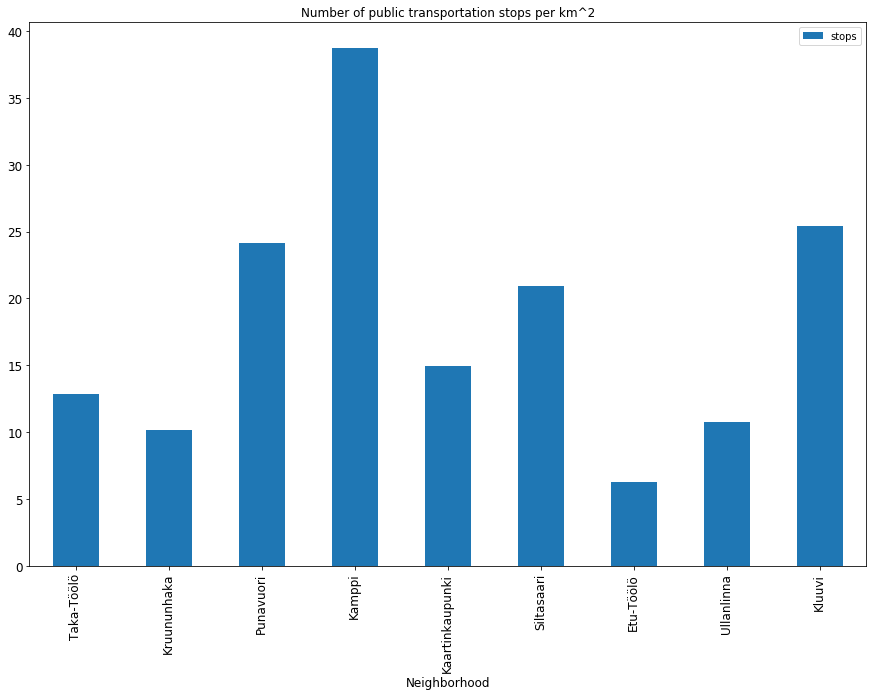

In [31]:
df_public_transportation.index = df_public_transportation["neighborhood"]
ax = df_public_transportation.plot(kind="bar", title ="Number of public transportation stops per km^2",figsize=(15,10),fontsize=12)
ax.set_xlabel("Neighborhood",fontsize=12)
ax.plot()

## Clustering restaurants

Next we'll cluster the restaurants based on the neighborhood

In [32]:
# one hot encoding
restaurants_onehot = pd.get_dummies(restaurants[['categories']], prefix="", prefix_sep="")

restaurants_onehot['neighborhood'] = restaurants['neighborhood'] 

fixed_columns = [restaurants_onehot.columns[-1]] + list(restaurants_onehot.columns[:-1])
restaurants_onehot = restaurants_onehot[fixed_columns]

restaurants_onehot.head()

,neighborhood,american restaurant,anatolian kitchen,asian restaurant,bar,billiards hall with kitchen,bistro,bold and authentic,"breakfast, baked goods",cafe,...,sweets bakery,tapas,tasty authentic,tea house,thai restaurant,tila online tuo kotiin,turkish,vegetarian restaurant,vietnamese restaurant,wine bar
0,Taka-Töölö,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Kruununhaka,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Punavuori,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Kamppi,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
7,Kaartinkaupunki,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [33]:
restaurants_onehot["neighborhood"].unique()

array(['Taka-Töölö', 'Kruununhaka', 'Punavuori', 'Kamppi',
       'Kaartinkaupunki', 'Siltasaari', 'Etu-Töölö', 'Ullanlinna',
       'Kluuvi'], dtype=object)

In [34]:
restaurants_neighborhood = restaurants_onehot.groupby('neighborhood').mean().reset_index()

num_top_venues = 5

for hood in restaurants_neighborhood['neighborhood']:
    print("----"+hood+"----")
    temp = restaurants_neighborhood[restaurants_neighborhood['neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Etu-Töölö----
                venue  freq
0          restaurant  0.11
1  finnish restaurant  0.11
2                cafe  0.11
3             falafel  0.06
4              danish  0.06


----Kaartinkaupunki----
                     venue  freq
0  scandinavian restaurant  0.11
1               restaurant  0.11
2       finnish restaurant  0.11
3                 wine bar  0.05
4        caviar, champagne  0.05


----Kamppi----
                venue  freq
0          restaurant  0.12
1                cafe  0.07
2  chinese restaurant  0.05
3  italian restaurant  0.05
4    sushi restaurant  0.05


----Kluuvi----
                venue  freq
0          restaurant  0.22
1                cafe  0.18
2  italian restaurant  0.09
3         pizza place  0.05
4           gastropub  0.04


----Kruununhaka----
                     venue  freq
0       finnish restaurant  0.18
1       italian restaurant  0.14
2              pizza place  0.14
3  scandinavian restaurant  0.09
4                     cafe  0.09


In [35]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [40]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['neighborhood'] = restaurants_neighborhood['neighborhood']

for ind in np.arange(restaurants_neighborhood.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(restaurants_neighborhood.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Etu-Töölö,restaurant,cafe,finnish restaurant,danish,chinese restaurant,pizzeria,japanese restaurant,"fast,fresh, fit,",falafel,russian restaurant
1,Kaartinkaupunki,scandinavian restaurant,finnish restaurant,restaurant,steak-restaurant,indian restaurant,greek restaurant,german,european,seafood,coffee shop
2,Kamppi,restaurant,cafe,italian restaurant,chinese restaurant,sushi restaurant,nepalese restaurant,mexican restaurant,japanese restaurant,coffee shop,pub
3,Kluuvi,restaurant,cafe,italian restaurant,pizza place,gastropub,finnish restaurant,mexican restaurant,fast kebab,indian restaurant,american restaurant
4,Kruununhaka,finnish restaurant,italian restaurant,pizza place,scandinavian restaurant,cafe,restaurant,asian restaurant,korean,tasty authentic,german cafe
5,Punavuori,restaurant,japanese restaurant,italian restaurant,cafe,pizza place,asian restaurant,finnish restaurant,coffee shop,design restaurant,deli / shop
6,Siltasaari,restaurant,cafe,nepalese restaurant,fast kebab,soup place,coffee shop,chinese restaurant,sushi restaurant,falafel,"fast,fresh, fit,"
7,Taka-Töölö,restaurant,cafe,japanese restaurant,indian restaurant,asian restaurant,italian restaurant,finnish restaurant,pizza place,mexican restaurant,nepalese restaurant
8,Ullanlinna,pizza place,finnish restaurant,restaurant,italian restaurant,french restaurant,russian restaurant,spanish restaurant,cafe-terrace,international,german


In [41]:
# set number of clusters
kclusters = 5

restaurants_neighborhood_clustering = restaurants_neighborhood.drop('neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(restaurants_neighborhood_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_ 

array([1, 4, 2, 2, 0, 2, 3, 2, 0], dtype=int32)

In [42]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_ + 1)


Based on clustering we can see that the cluster 3 (Kamppi, Kluuvi, Punavuori and Taka-töölö) are quite similar driven by "generic" restaurants and cafes. And this makes sense since these areas also contain a lot of businesses and therefore a lot of lunch restaurants and cafes.

Cluster 5 seems to be drive by the more upscale restaurants and restaurants with more specific profile.

Cluster 2 has again more generic restaurants and cafe and strong ethnic flavour.

Cluster 4 looks like quite similar to cluster 2

Cluster 1 is similar to cluster 5

Let's visualize the clusters on a map

In [43]:
hki_map2 = folium.Map(location=[latitude, longitude], zoom_start=13)
neighborhoods2 = "helsinki2.geojson"

style_function2 = lambda x: {'fillColor': '#00FFFFFF',
                 'lineColor': '#00FFFFFF',
                           'weight': 0.5,
                           'fillOpacity' : 0.1,}

hki_map2.choropleth(
    neighborhoods2,data=neighborhoods_venues_sorted,
    columns=['neighborhood', 'Cluster Labels'],
    key_on='properties.NIMI',
    fill_color='YlGn', fill_opacity=0.7, line_opacity=0.2,
    legend_name='Cluster index'
)

hki_map2

/anaconda/lib/python3.6/site-packages/folium/folium.py:432: FutureWarning: The choropleth  method has been deprecated. Instead use the new Choropleth class, which has the same arguments. See the example notebook 'GeoJSON_and_choropleth' for how to do this.
  FutureWarning


Let's investigate restaurants price categories and reviews

In [44]:
restaurants.groupby("neighborhood").mean()

,price,review
neighborhood,,
Etu-Töölö,1.722222,6.888889
Kaartinkaupunki,2.210526,7.789474
Kamppi,1.670000,6.440000
Kluuvi,2.072727,5.454545
Kruununhaka,1.636364,6.909091
Punavuori,0.878788,5.393939
Siltasaari,0.533333,5.200000
Taka-Töölö,2.073171,6.243902
Ullanlinna,1.928571,6.142857


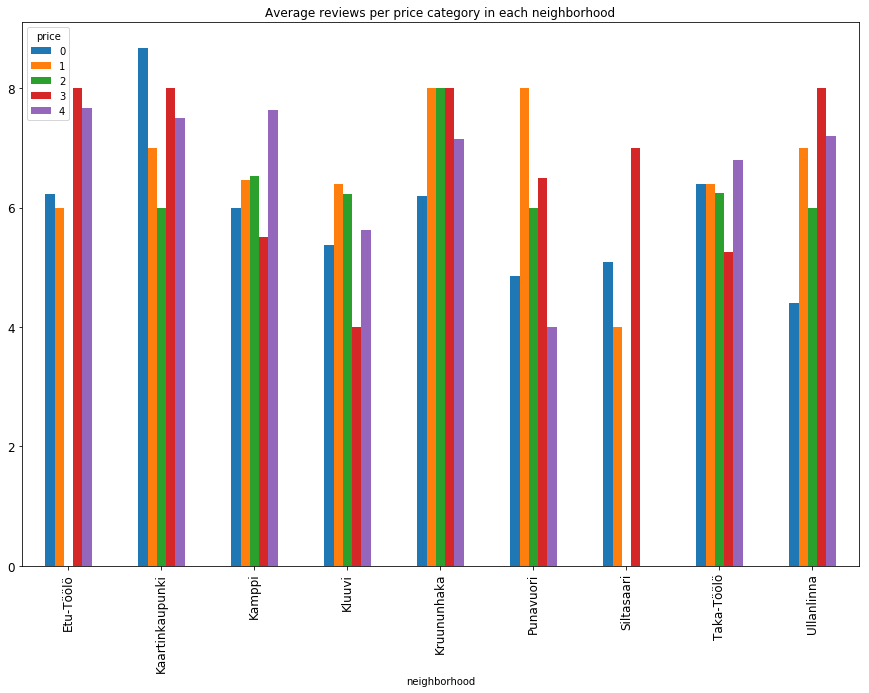

In [45]:
restaurants.pivot_table(index="neighborhood", columns="price", values="review").plot(kind="bar",title="Average reviews per price category in each neighborhood",figsize=(15,10),fontsize=12)

In [46]:
restaurants.groupby("neighborhood").max()

,name,categories,price,review
neighborhood,,,,
Etu-Töölö,Troikka,vietnamese restaurant,4,8
Kaartinkaupunki,Zucchini,wine bar,4,10
Kamppi,cafe rouge,wine bar,4,10
Kluuvi,Woolshed Helsinki,tapas,4,8
Kruununhaka,Taverna Vaelsa,tasty authentic,4,10
Punavuori,The Boom Room,turkish,4,10
Siltasaari,Sävel,sushi restaurant,3,8
Taka-Töölö,sushi wa.gocoro,tapas,4,10
Ullanlinna,Teranga,spanish restaurant,4,8


Finally we would like to understand what kind of restaurant concepts exists in Helsinki. For this let's group the restaurants by the category.

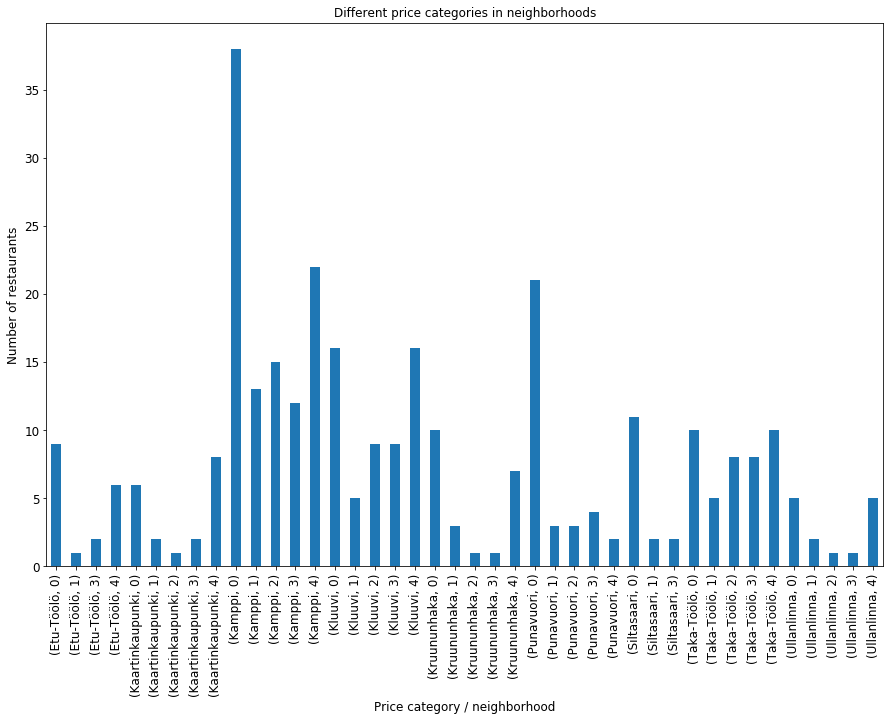

In [47]:
#prices = restaurants[["neighborhood","price"]]
prices = restaurants.groupby(["neighborhood","price"]).count()
ax = prices.plot(kind="bar",  y="name", title="Different price categories in neighborhoods", figsize=(15,10),fontsize=12)
ax.set_xlabel("Price category / neighborhood",fontsize=12)
ax.set_ylabel("Number of restaurants",fontsize=12)
ax.get_legend().remove()



Based on the order two key points can be identified:
1. Restaurant needs a clear concept - there are plenty of generic restaurants in Helsinki
2. Finnish and Asian cuisine is quite well covered